In [100]:
#Imports 
import torch
import os
import numpy as np
import torch_geometric

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [101]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
data = dataset[0]


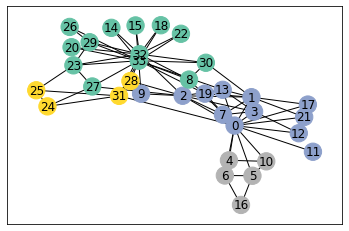

In [102]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
nx.draw_networkx(G, node_color=data.y,cmap="Set2")

In [103]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)
        x = x.tanh()

        out = self.classifier(x)

        return out, x
    

In [104]:
def check_accuracy(out):
    pred = np.asarray(out.argmax(dim=1))
    originals = np.asarray(data.y)
    correct = 0
    for i in range(34):
        correct += pred[i] == originals[i]
    return correct/34

In [105]:
def visualize_embedding(out, h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Accuracy: {check_accuracy(out)}', fontsize=16)
    plt.show()

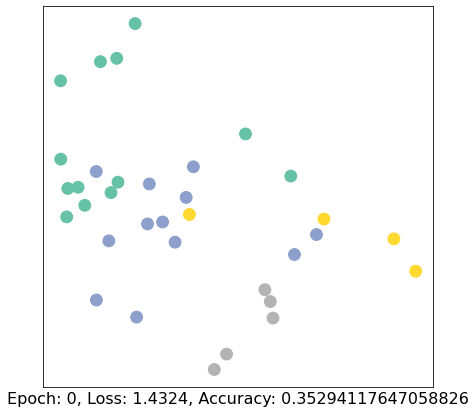

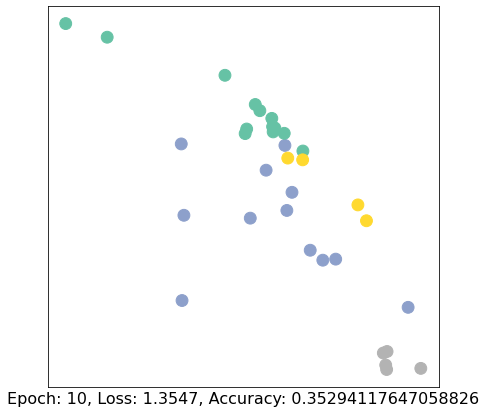

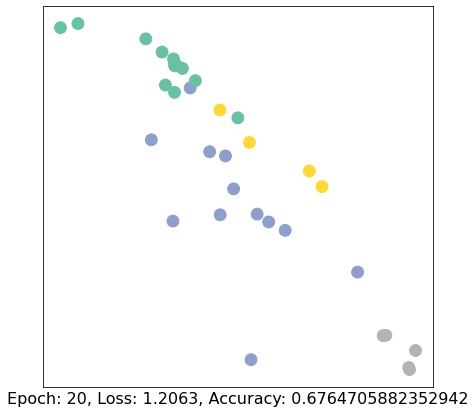

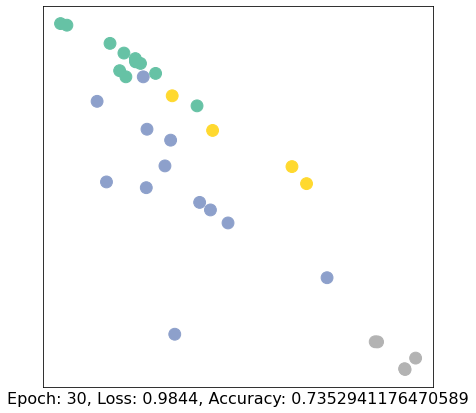

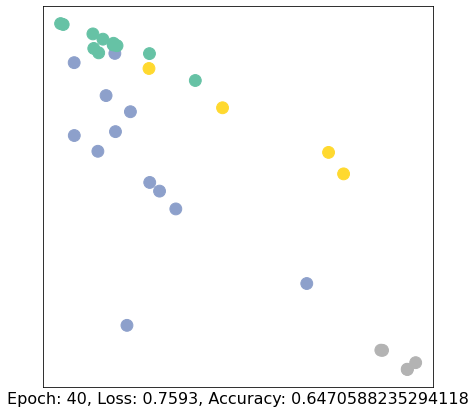

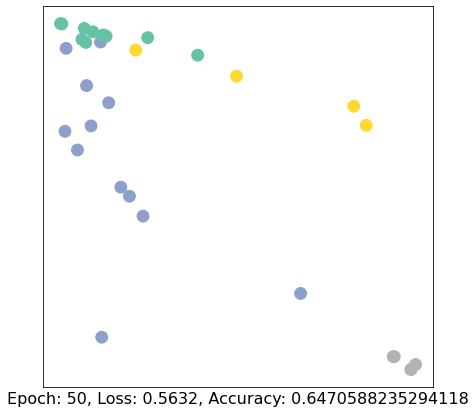

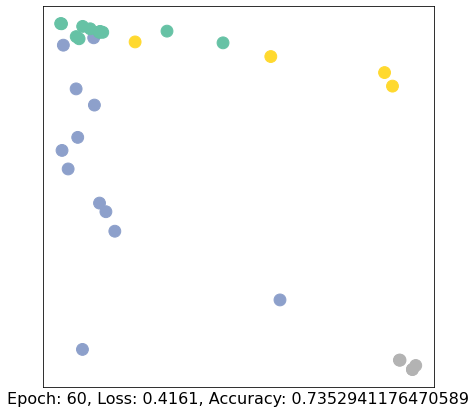

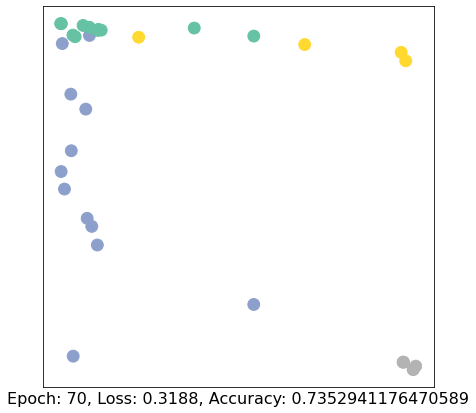

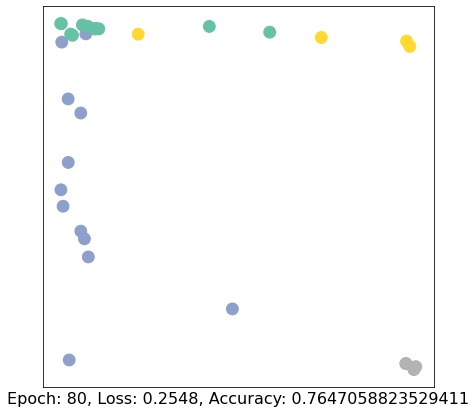

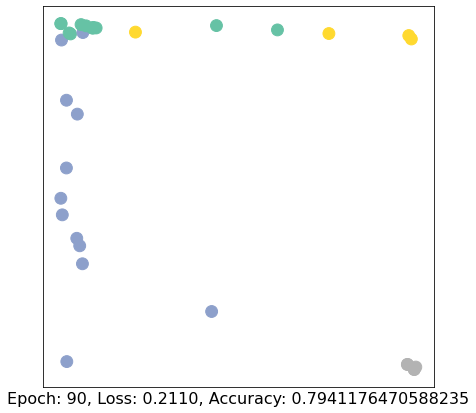

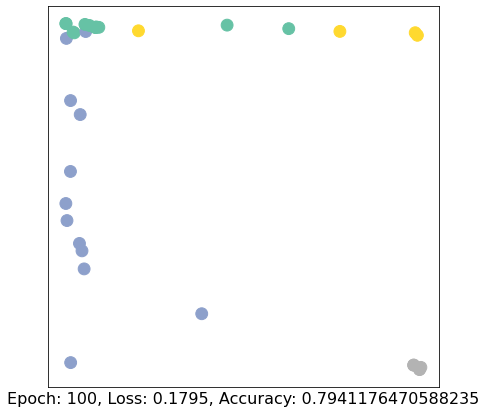

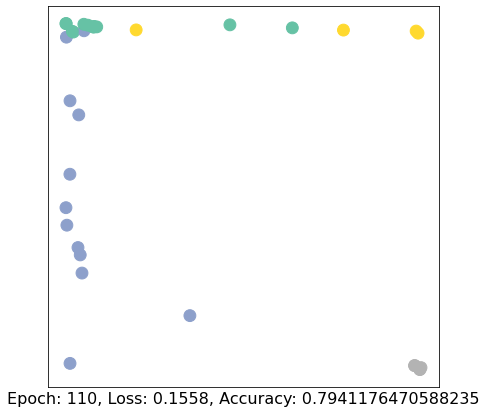

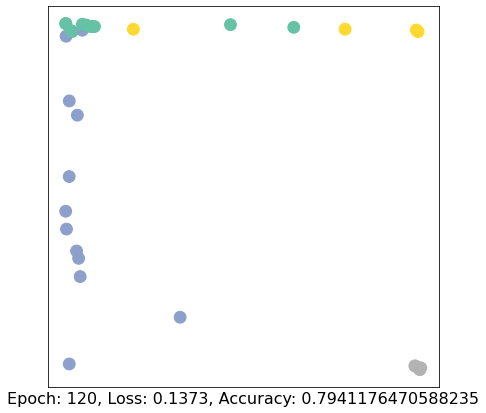

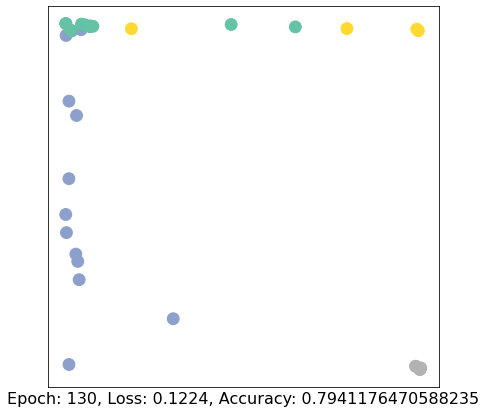

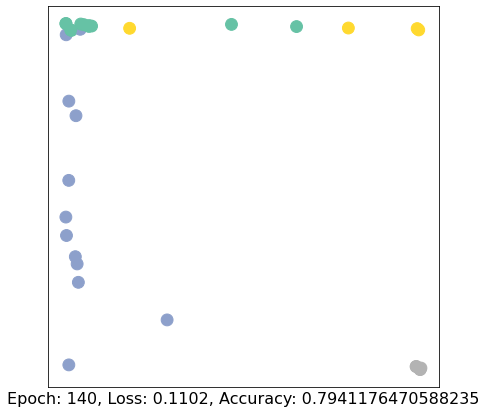

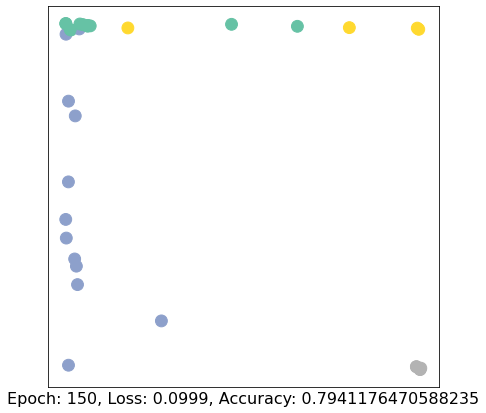

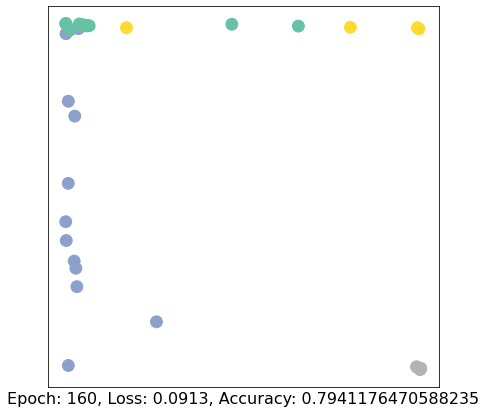

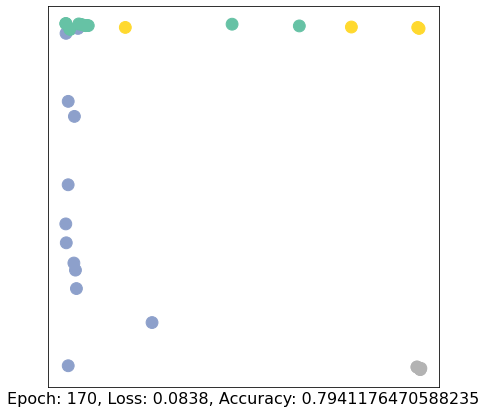

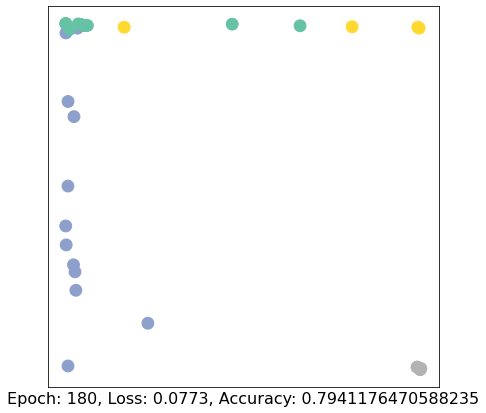

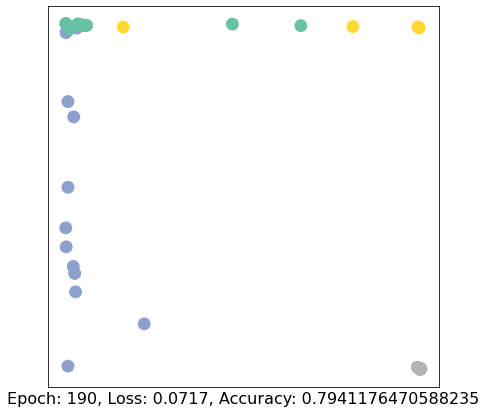

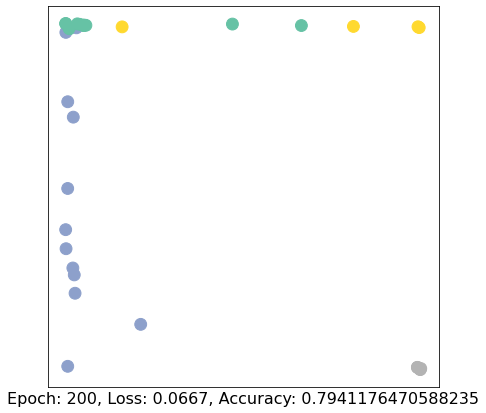

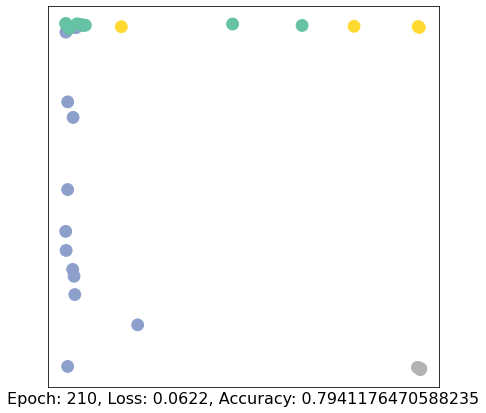

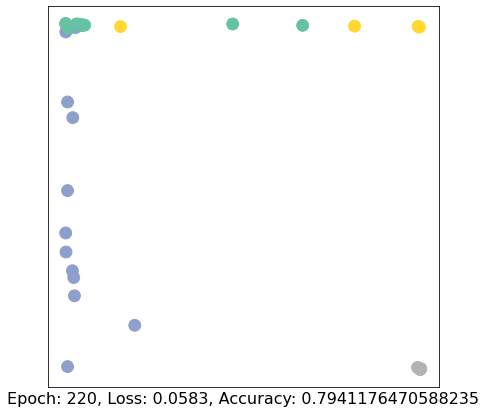

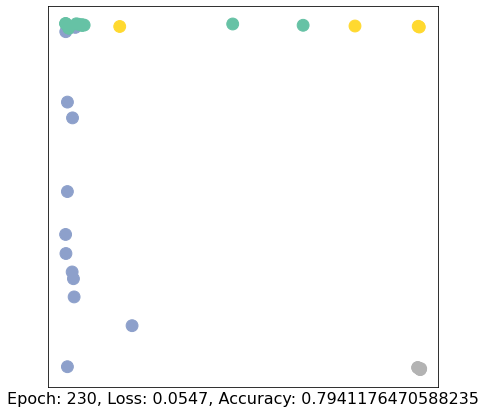

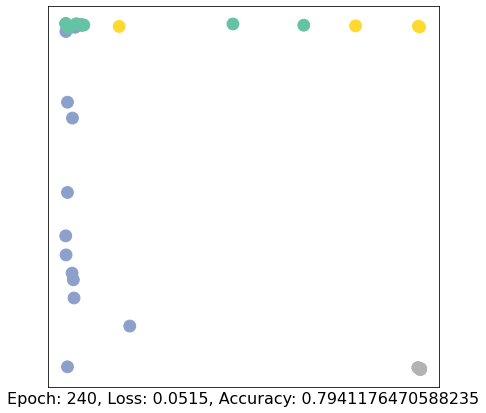

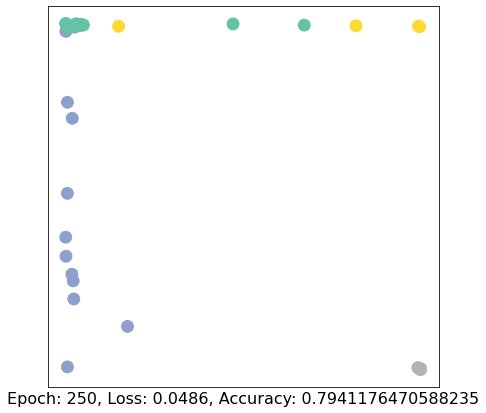

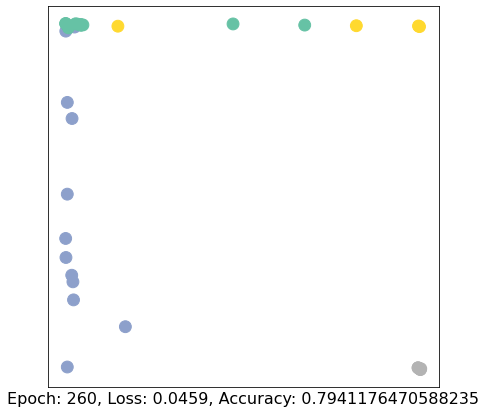

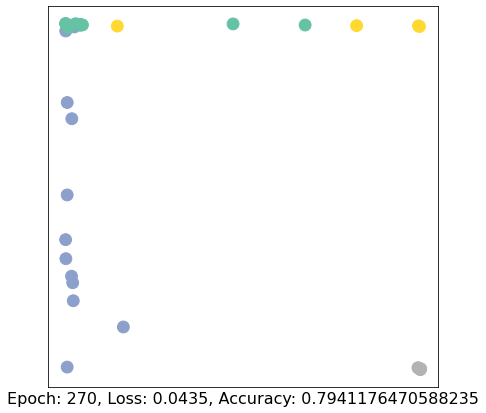

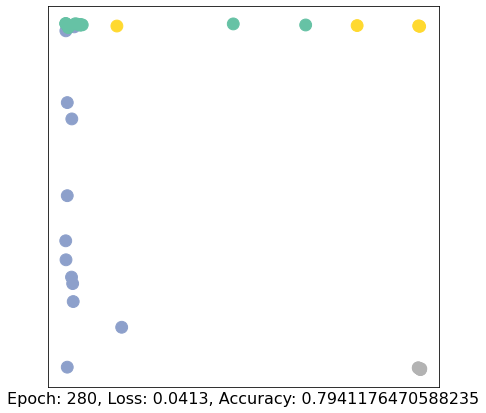

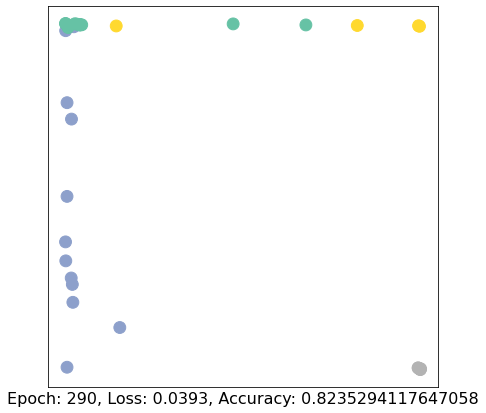

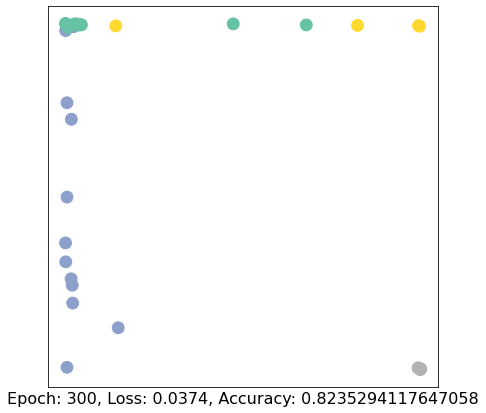

In [109]:
import time
model = GCN()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return out, loss, h

for epoch in range(301):
    out, loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(out, h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)